# Jeremy Gomes, Adly Zaroui M2IM
**Final Graded Assignement / LipReading\
Statistical Computational Methods**
***

# Table of Contents

0. [Data Preprocessing](#0.-Data-Preprocessing)
1. [dimension reduction with PCA](#1.-PCA-as-a-dimension-reduction-tool)
2. [Classification with a Random Forest Classifier](#2.-Random-Forest)
3. [Classification with a Random Forest Classifier on reduced data](#3.-Random-Forest-over-PCA)
4. [Classification with a Bagging Random Forest Classifier on reduced data](#4.-Bagging-Random-Forest-over-PCA)
***

In this first part, we will generate conventional frames from event data, in order to use them as input for classical classification video algorithms.
The event_agg script is partially copied from <a href='https://www.kaggle.com/code/gogo827jz/generating-superframes-from-dvs-event-data/notebook'> this Kaggle Notebook </a>

In [28]:
import cv2
import numpy as np
import pandas as pd
import datatable as dtable
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from time import time
import seaborn as sns

# Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score

# 0. Data Preprocessing

Here, we will define a function that convert an event file into a sequence of frame

In [2]:
def event_agg(x, y, polarity, timestamp, T_r, M, N): #T_r: time intervel, M: image length, N: image width
    T_seq = timestamp.max()
    T_frames = int((T_seq // T_r)) + 1
    
    frames_0 = np.zeros((T_frames, M, N)) # polarity == 0
    frames_1 = np.zeros((T_frames, M, N)) # polarity == 1
    
    for i in tqdm(range(T_frames)):
        idx_0 = np.where((timestamp >= i * T_r) & (timestamp < (i+1) * T_r) & (polarity == 0))[0]
        if len(idx_0) > 0:
            frames_0[i] = np.bincount(N * x[idx_0] + y[idx_0], minlength = M * N).reshape(M, N)
        
        idx_1 = np.where((timestamp >= i * T_r) & (timestamp < (i+1) * T_r) & (polarity == 1))[0]
        if len(idx_1) > 0:
            frames_1[i] = np.bincount(N * x[idx_1] + y[idx_1], minlength = M * N).reshape(M, N)
    
    superframes = np.concatenate((frames_0, frames_1), axis = 0)
    print('generated superframes with size:', superframes.shape)
    return superframes

In [3]:
def resize(superframes,n,p,q):
    
    resized_superframes = []
    
    for i in range(n):
        frame = superframes[i]
        frame = cv2.resize(frame, (q,p), interpolation = cv2.INTER_AREA) # cv2 transpose
        resized_superframes.append(frame)
        
    resized_superframes = np.asarray(resized_superframes)
    resized_superframes  = resized_superframes.reshape(n,p,q)
    
    print('resized superframes with size:', resized_superframes.shape)
    
    return resized_superframes

## 0.1 Video plot
Now we are able to visualize a video, by executing the following cell

  0%|          | 0/30 [00:00<?, ?it/s]

generated superframes with size: (60, 640, 480)


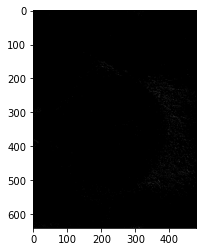

In [24]:
path = '/Users/adly/Desktop/SCM/smemi309-final-evaluation-challenge-2022/test10/test10'
file = dtable.fread(path + '/0.csv', sep = ',').to_pandas()
file.columns = ['x', 'y', 'polarity', 'timestamp']

T_r = 100000
M = 640
N = 480

x = np.array(file['x'].values)
y = np.array(file['y'].values)
polarity = np.array(file['polarity'].values)
timestamp = np.array(file['timestamp'].values)

superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)

frames = [] # for storing the generated images
fig = plt.figure()
for i in range(superframes.shape[0]):
    frames.append([plt.imshow(superframes[i], cmap = cm.Greys_r, animated = True)])

ani = animation.ArtistAnimation(fig, frames, interval = 50, blit = False, repeat_delay = 1000)
#ani.save('video.mp4')
HTML(ani.to_jshtml())

***

## 0.2 Data Loading

convert event data into frames, stacking each video into list of 3D matrices.
Each word utterance will be converted into a frame sequence. \
We will built X and z respectively list of videos and label.

In [4]:
T_r = 205000
M = 640
N = 480
X = []
z = []
path = '/Users/adly/Desktop/SCM/smemi309-final-evaluation-challenge-2022/train10/train10'
################################################## Addition ###################################################
label = 0
for i in tqdm(range(32)):
    
    file = dtable.fread(path + '/Addition/' + str(i) + '.csv', sep = ',').to_pandas()
    file.columns = ['x', 'y', 'polarity', 'timestamp']
    
    x = np.array(file['x'].values)
    y = np.array(file['y'].values)
    polarity = np.array(file['polarity'].values)
    timestamp = np.array(file['timestamp'].values)
    
    superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)
    superframes = resize(superframes, 30,160,120)
    
    X.append(superframes)
    z.append(label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


In [5]:
################################################## Carnaval ###################################################

label = 1
for i in tqdm(range(32)):
    
    file = dtable.fread(path + '/Carnaval/' + str(i) + '.csv', sep = ',').to_pandas()
    file.columns = ['x', 'y', 'polarity', 'timestamp']
    
    x = np.array(file['x'].values)
    y = np.array(file['y'].values)
    polarity = np.array(file['polarity'].values)
    timestamp = np.array(file['timestamp'].values)
    
    superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)
    superframes = resize(superframes, 30,160,120)
    
    X.append(superframes)
    z.append(label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


In [6]:
################################################## Decider ###################################################

label = 2
for i in tqdm(range(32)):
    
    file = dtable.fread(path + '/Decider/' + str(i) + '.csv', sep = ',').to_pandas()
    file.columns = ['x', 'y', 'polarity', 'timestamp']
    
    x = np.array(file['x'].values)
    y = np.array(file['y'].values)
    polarity = np.array(file['polarity'].values)
    timestamp = np.array(file['timestamp'].values)
    
    superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)
    superframes = resize(superframes, 30,160,120)
    
    X.append(superframes)
    z.append(label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


In [7]:
################################################## Ecole ###################################################

label = 3
for i in tqdm(range(32)):
    
    file = dtable.fread(path + '/Ecole/' + str(i) + '.csv', sep = ',').to_pandas()
    file.columns = ['x', 'y', 'polarity', 'timestamp']
    
    x = np.array(file['x'].values)
    y = np.array(file['y'].values)
    polarity = np.array(file['polarity'].values)
    timestamp = np.array(file['timestamp'].values)
    
    superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)
    superframes = resize(superframes, 30,160,120)
    
    X.append(superframes)
    z.append(label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


In [8]:
################################################## Fillette ###################################################

label = 4
for i in tqdm(range(32)):
    
    file = dtable.fread(path + '/Fillette/' + str(i) + '.csv', sep = ',').to_pandas()
    file.columns = ['x', 'y', 'polarity', 'timestamp']
    
    x = np.array(file['x'].values)
    y = np.array(file['y'].values)
    polarity = np.array(file['polarity'].values)
    timestamp = np.array(file['timestamp'].values)
    
    superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)
    superframes = resize(superframes, 30,160,120)
    
    X.append(superframes)
    z.append(label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


In [9]:
################################################## Huitre ###################################################

label = 5
for i in tqdm(range(32)):
    
    file = dtable.fread(path + '/Huitre/' + str(i) + '.csv', sep = ',').to_pandas()
    file.columns = ['x', 'y', 'polarity', 'timestamp']
    
    x = np.array(file['x'].values)
    y = np.array(file['y'].values)
    polarity = np.array(file['polarity'].values)
    timestamp = np.array(file['timestamp'].values)
    
    superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)
    superframes = resize(superframes, 30,160,120)
    
    X.append(superframes)
    z.append(label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


In [10]:
################################################## Joyeux ###################################################

label = 6
for i in tqdm(range(32)):
    
    file = dtable.fread(path + '/Joyeux/' + str(i) + '.csv', sep = ',').to_pandas()
    file.columns = ['x', 'y', 'polarity', 'timestamp']
    
    x = np.array(file['x'].values)
    y = np.array(file['y'].values)
    polarity = np.array(file['polarity'].values)
    timestamp = np.array(file['timestamp'].values)
    
    superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)
    superframes = resize(superframes, 30,160,120)
    
    X.append(superframes)
    z.append(label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


In [11]:
################################################## Pyjama ###################################################

label = 7
for i in tqdm(range(32)):
    
    file = dtable.fread(path + '/Pyjama/' + str(i) + '.csv', sep = ',').to_pandas()
    file.columns = ['x', 'y', 'polarity', 'timestamp']
    
    x = np.array(file['x'].values)
    y = np.array(file['y'].values)
    polarity = np.array(file['polarity'].values)
    timestamp = np.array(file['timestamp'].values)
    
    superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)
    superframes = resize(superframes, 30,160,120)
    
    X.append(superframes)
    z.append(label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


In [12]:
################################################## Ruisseau ###################################################

label = 8
for i in tqdm(range(32)):
    
    file = dtable.fread(path + '/Ruisseau/' + str(i) + '.csv', sep = ',').to_pandas()
    file.columns = ['x', 'y', 'polarity', 'timestamp']
    
    x = np.array(file['x'].values)
    y = np.array(file['y'].values)
    polarity = np.array(file['polarity'].values)
    timestamp = np.array(file['timestamp'].values)
    
    superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)
    superframes = resize(superframes, 30,160,120)
    
    X.append(superframes)
    z.append(label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


In [13]:
################################################## Musique ###################################################

label = 9
for i in tqdm(range(32)):
    
    file = dtable.fread(path + '/Musique/' + str(i) + '.csv', sep = ',').to_pandas()
    file.columns = ['x', 'y', 'polarity', 'timestamp']
    
    x = np.array(file['x'].values)
    y = np.array(file['y'].values)
    polarity = np.array(file['polarity'].values)
    timestamp = np.array(file['timestamp'].values)
    
    superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)
    superframes = resize(superframes, 30,160,120)
    
    X.append(superframes)
    z.append(label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


  0%|          | 0/15 [00:00<?, ?it/s]

generated superframes with size: (30, 640, 480)
resized superframes with size: (30, 160, 120)


In [14]:
del label, file, x, y, polarity, timestamp, superframes

In [15]:
# flat X_train
Y = []
n = len(X)
for i in range(n):
    Y.append(X[0].reshape(1,30*160*120))
    del X[0]
X = Y
del Y

X = np.array(X)
X = X.reshape(320,30*160*120)

In [16]:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, stratify = z)
del X

***

# 1. PCA as a dimension reduction tool

For us, one video is of shape (30, 160, 120) : 30 frames of 160x120 np array images.\
First, we will vectorize this array into a vector of length 30*160x120 = 576000\
We will then apply pca.

In [17]:
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print('Number of training samples: ', X_train.shape[0])
print('Initial dimension: ', X_train.shape[1])
print('Number of PCA dimensions: ', pca.n_components_)

Number of training samples:  256
Initial dimension:  576000
Number of PCA dimensions:  216


[0.17373634 0.07468236]


<Figure size 7200x4800 with 0 Axes>

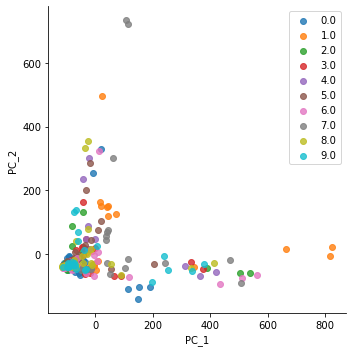

In [31]:
# Clusters Visualization

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit(X_train).transform(X_train)


print(pca2.explained_variance_ratio_)

plt.figure(dpi=1200)
zX_pca2 = np.c_[z_train,X_pca2]
zX_pca2_df = pd.DataFrame(zX_pca2)
zX_pca2_df.columns = ["mots","PC_1","PC_2"]
sns.lmplot( x="PC_1", y="PC_2", data=zX_pca2_df, fit_reg=False, hue="mots", legend=False)
plt.legend(loc='best')  # 'upper center', 'lower center', 'center left', 'center right'  'upper left', 'upper right', 'lower left', 'lower right'
plt.savefig('/Users/adly/Desktop/SCM/SCM LipReading/plots/plot2componentsPCAClusters.png', dpi=200)
plt.show()

## 1.1 Kmeans

In [18]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_train_pca)
kmeans.score(X_test_pca)

-3772379.235739678

In [19]:
predictions = kmeans.predict(X_test_pca).tolist()

In [20]:
accuracy = sum([int(predictions[i] == z_test[i]) for i in range(64)])/64 # len(prediciton) = 64
print(accuracy)

0.125


In [21]:
print(cross_val_score(kmeans, X_train_pca, cv=5))

[-5883338.36752952 -6416076.62306502 -5983203.25273492 -5909850.04052081
 -5726941.0802347 ]


In [22]:
def silhouette_score_cv(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

clf = cross_val_score(kmeans, X_train_pca, cv=5, scoring=silhouette_score_cv)
print(clf)

[0.29617732 0.13699306 0.27783994 0.1516725  0.25585628]


# 2. Random Forest

## 2.1 Training
Hyperparameters tuning

In [25]:
acc_train = []
acc_test = []
t1 = time()
for mdepth in tqdm(np.arange(1,200,20)):
    for nestimator in tqdm(np.arange(1,200,20)):
        rf_clf = RandomForestClassifier(max_depth=mdepth, n_estimators = nestimator).fit(X_train, z_train)
        acc_train.append(rf_clf.score(X_train, z_train))
        acc_test.append(rf_clf.score(X_test, z_test))
        print('m_depth = ' + str(mdepth) + ', n_estimators = ' + str(nestimator) + ' : complete !\n')
t2 = time()
print('computation time : ' + str(round(t2-t1,2)) + 's')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 1, n_estimators = 1 : complete !

m_depth = 1, n_estimators = 21 : complete !

m_depth = 1, n_estimators = 41 : complete !

m_depth = 1, n_estimators = 61 : complete !

m_depth = 1, n_estimators = 81 : complete !

m_depth = 1, n_estimators = 101 : complete !

m_depth = 1, n_estimators = 121 : complete !

m_depth = 1, n_estimators = 141 : complete !

m_depth = 1, n_estimators = 161 : complete !

m_depth = 1, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 21, n_estimators = 1 : complete !

m_depth = 21, n_estimators = 21 : complete !

m_depth = 21, n_estimators = 41 : complete !

m_depth = 21, n_estimators = 61 : complete !

m_depth = 21, n_estimators = 81 : complete !

m_depth = 21, n_estimators = 101 : complete !

m_depth = 21, n_estimators = 121 : complete !

m_depth = 21, n_estimators = 141 : complete !

m_depth = 21, n_estimators = 161 : complete !

m_depth = 21, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 41, n_estimators = 1 : complete !

m_depth = 41, n_estimators = 21 : complete !

m_depth = 41, n_estimators = 41 : complete !

m_depth = 41, n_estimators = 61 : complete !

m_depth = 41, n_estimators = 81 : complete !

m_depth = 41, n_estimators = 101 : complete !

m_depth = 41, n_estimators = 121 : complete !

m_depth = 41, n_estimators = 141 : complete !

m_depth = 41, n_estimators = 161 : complete !

m_depth = 41, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 61, n_estimators = 1 : complete !

m_depth = 61, n_estimators = 21 : complete !

m_depth = 61, n_estimators = 41 : complete !

m_depth = 61, n_estimators = 61 : complete !

m_depth = 61, n_estimators = 81 : complete !

m_depth = 61, n_estimators = 101 : complete !

m_depth = 61, n_estimators = 121 : complete !

m_depth = 61, n_estimators = 141 : complete !

m_depth = 61, n_estimators = 161 : complete !

m_depth = 61, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 81, n_estimators = 1 : complete !

m_depth = 81, n_estimators = 21 : complete !

m_depth = 81, n_estimators = 41 : complete !

m_depth = 81, n_estimators = 61 : complete !

m_depth = 81, n_estimators = 81 : complete !

m_depth = 81, n_estimators = 101 : complete !

m_depth = 81, n_estimators = 121 : complete !

m_depth = 81, n_estimators = 141 : complete !

m_depth = 81, n_estimators = 161 : complete !

m_depth = 81, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 101, n_estimators = 1 : complete !

m_depth = 101, n_estimators = 21 : complete !

m_depth = 101, n_estimators = 41 : complete !

m_depth = 101, n_estimators = 61 : complete !

m_depth = 101, n_estimators = 81 : complete !

m_depth = 101, n_estimators = 101 : complete !

m_depth = 101, n_estimators = 121 : complete !

m_depth = 101, n_estimators = 141 : complete !

m_depth = 101, n_estimators = 161 : complete !

m_depth = 101, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 121, n_estimators = 1 : complete !

m_depth = 121, n_estimators = 21 : complete !

m_depth = 121, n_estimators = 41 : complete !

m_depth = 121, n_estimators = 61 : complete !

m_depth = 121, n_estimators = 81 : complete !

m_depth = 121, n_estimators = 101 : complete !

m_depth = 121, n_estimators = 121 : complete !

m_depth = 121, n_estimators = 141 : complete !

m_depth = 121, n_estimators = 161 : complete !

m_depth = 121, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 141, n_estimators = 1 : complete !

m_depth = 141, n_estimators = 21 : complete !

m_depth = 141, n_estimators = 41 : complete !

m_depth = 141, n_estimators = 61 : complete !

m_depth = 141, n_estimators = 81 : complete !

m_depth = 141, n_estimators = 101 : complete !

m_depth = 141, n_estimators = 121 : complete !

m_depth = 141, n_estimators = 141 : complete !

m_depth = 141, n_estimators = 161 : complete !

m_depth = 141, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 161, n_estimators = 1 : complete !

m_depth = 161, n_estimators = 21 : complete !

m_depth = 161, n_estimators = 41 : complete !

m_depth = 161, n_estimators = 61 : complete !

m_depth = 161, n_estimators = 81 : complete !

m_depth = 161, n_estimators = 101 : complete !

m_depth = 161, n_estimators = 121 : complete !

m_depth = 161, n_estimators = 141 : complete !

m_depth = 161, n_estimators = 161 : complete !

m_depth = 161, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 181, n_estimators = 1 : complete !

m_depth = 181, n_estimators = 21 : complete !

m_depth = 181, n_estimators = 41 : complete !

m_depth = 181, n_estimators = 61 : complete !

m_depth = 181, n_estimators = 81 : complete !

m_depth = 181, n_estimators = 101 : complete !

m_depth = 181, n_estimators = 121 : complete !

m_depth = 181, n_estimators = 141 : complete !

m_depth = 181, n_estimators = 161 : complete !

m_depth = 181, n_estimators = 181 : complete !

computation time : 1159.69s


## 2.2 Plot

In [ ]:
fig = plt.figure()

X = np.arange(1, 200, 20)
Y = np.arange(1, 200, 20)
X, Y = np.meshgrid(X, Y)
Z1 = np.array(acc_train).reshape(10,10)
Z2 = np.array(acc_test).reshape(10,10)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_zlim(-0.01, 1.01)
plt.title('train', fontsize=11)
surf1 = ax.plot_surface(X, Y, Z1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('n_clusters', fontsize=9, rotation=150)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_zlim(-0.01, 1.01)
plt.title('test', fontsize=11)
surf2 = ax.plot_surface(X, Y, Z2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf2, shrink=0.5, aspect=5, location = 'bottom')
ax.set_xlabel('max_depth', fontsize=9, rotation=150)
ax.set_zlabel('accuracy', fontsize=9, rotation=150)
#plt.savefig('/Users/adly/Desktop/SCM/SCM LipReading/plots/plotRFtrainTestAccuracy.png', dpi=200)
plt.show()

#  3. Random Forest over PCA

## 3.1. Training
Hyperparameters tuning

In [26]:
acc_train = []
acc_test = []
t1 = time()
for mdepth in tqdm(np.arange(1,200,20)):
    for nestimator in tqdm(np.arange(1,200,20)):
        rf_clf = RandomForestClassifier(max_depth=mdepth, n_estimators=nestimator).fit(X_train_pca, z_train)
        acc_train.append(rf_clf.score(X_train_pca, z_train))
        acc_test.append(rf_clf.score(X_test_pca, z_test))
        print('m_depth = ' + str(mdepth) + ', n_estimators = ' + str(nestimator) + ' : complete !\n')
t2 = time()
print('computation time : ' + str(round(t2-t1,2)) + 's')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 1, n_estimators = 1 : complete !

m_depth = 1, n_estimators = 21 : complete !

m_depth = 1, n_estimators = 41 : complete !

m_depth = 1, n_estimators = 61 : complete !

m_depth = 1, n_estimators = 81 : complete !

m_depth = 1, n_estimators = 101 : complete !

m_depth = 1, n_estimators = 121 : complete !

m_depth = 1, n_estimators = 141 : complete !

m_depth = 1, n_estimators = 161 : complete !

m_depth = 1, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 21, n_estimators = 1 : complete !

m_depth = 21, n_estimators = 21 : complete !

m_depth = 21, n_estimators = 41 : complete !

m_depth = 21, n_estimators = 61 : complete !

m_depth = 21, n_estimators = 81 : complete !

m_depth = 21, n_estimators = 101 : complete !

m_depth = 21, n_estimators = 121 : complete !

m_depth = 21, n_estimators = 141 : complete !

m_depth = 21, n_estimators = 161 : complete !

m_depth = 21, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 41, n_estimators = 1 : complete !

m_depth = 41, n_estimators = 21 : complete !

m_depth = 41, n_estimators = 41 : complete !

m_depth = 41, n_estimators = 61 : complete !

m_depth = 41, n_estimators = 81 : complete !

m_depth = 41, n_estimators = 101 : complete !

m_depth = 41, n_estimators = 121 : complete !

m_depth = 41, n_estimators = 141 : complete !

m_depth = 41, n_estimators = 161 : complete !

m_depth = 41, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 61, n_estimators = 1 : complete !

m_depth = 61, n_estimators = 21 : complete !

m_depth = 61, n_estimators = 41 : complete !

m_depth = 61, n_estimators = 61 : complete !

m_depth = 61, n_estimators = 81 : complete !

m_depth = 61, n_estimators = 101 : complete !

m_depth = 61, n_estimators = 121 : complete !

m_depth = 61, n_estimators = 141 : complete !

m_depth = 61, n_estimators = 161 : complete !

m_depth = 61, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 81, n_estimators = 1 : complete !

m_depth = 81, n_estimators = 21 : complete !

m_depth = 81, n_estimators = 41 : complete !

m_depth = 81, n_estimators = 61 : complete !

m_depth = 81, n_estimators = 81 : complete !

m_depth = 81, n_estimators = 101 : complete !

m_depth = 81, n_estimators = 121 : complete !

m_depth = 81, n_estimators = 141 : complete !

m_depth = 81, n_estimators = 161 : complete !

m_depth = 81, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 101, n_estimators = 1 : complete !

m_depth = 101, n_estimators = 21 : complete !

m_depth = 101, n_estimators = 41 : complete !

m_depth = 101, n_estimators = 61 : complete !

m_depth = 101, n_estimators = 81 : complete !

m_depth = 101, n_estimators = 101 : complete !

m_depth = 101, n_estimators = 121 : complete !

m_depth = 101, n_estimators = 141 : complete !

m_depth = 101, n_estimators = 161 : complete !

m_depth = 101, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 121, n_estimators = 1 : complete !

m_depth = 121, n_estimators = 21 : complete !

m_depth = 121, n_estimators = 41 : complete !

m_depth = 121, n_estimators = 61 : complete !

m_depth = 121, n_estimators = 81 : complete !

m_depth = 121, n_estimators = 101 : complete !

m_depth = 121, n_estimators = 121 : complete !

m_depth = 121, n_estimators = 141 : complete !

m_depth = 121, n_estimators = 161 : complete !

m_depth = 121, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 141, n_estimators = 1 : complete !

m_depth = 141, n_estimators = 21 : complete !

m_depth = 141, n_estimators = 41 : complete !

m_depth = 141, n_estimators = 61 : complete !

m_depth = 141, n_estimators = 81 : complete !

m_depth = 141, n_estimators = 101 : complete !

m_depth = 141, n_estimators = 121 : complete !

m_depth = 141, n_estimators = 141 : complete !

m_depth = 141, n_estimators = 161 : complete !

m_depth = 141, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 161, n_estimators = 1 : complete !

m_depth = 161, n_estimators = 21 : complete !

m_depth = 161, n_estimators = 41 : complete !

m_depth = 161, n_estimators = 61 : complete !

m_depth = 161, n_estimators = 81 : complete !

m_depth = 161, n_estimators = 101 : complete !

m_depth = 161, n_estimators = 121 : complete !

m_depth = 161, n_estimators = 141 : complete !

m_depth = 161, n_estimators = 161 : complete !

m_depth = 161, n_estimators = 181 : complete !



  0%|          | 0/10 [00:00<?, ?it/s]

m_depth = 181, n_estimators = 1 : complete !

m_depth = 181, n_estimators = 21 : complete !

m_depth = 181, n_estimators = 41 : complete !

m_depth = 181, n_estimators = 61 : complete !

m_depth = 181, n_estimators = 81 : complete !

m_depth = 181, n_estimators = 101 : complete !

m_depth = 181, n_estimators = 121 : complete !

m_depth = 181, n_estimators = 141 : complete !

m_depth = 181, n_estimators = 161 : complete !

m_depth = 181, n_estimators = 181 : complete !

computation time : 39.26s


## 3.2 Plot

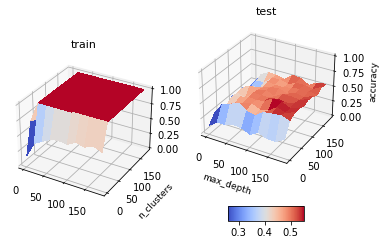

In [27]:
fig = plt.figure()

X = np.arange(1, 200, 20)
Y = np.arange(1, 200, 20)
X, Y = np.meshgrid(X, Y)
Z1 = np.array(acc_train).reshape(10,10)
Z2 = np.array(acc_test).reshape(10,10)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_zlim(-0.01, 1.01)
plt.title('train', fontsize=11)
surf1 = ax.plot_surface(X, Y, Z1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('n_clusters', fontsize=9, rotation=150)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_zlim(-0.01, 1.01)
plt.title('test', fontsize=11)
surf2 = ax.plot_surface(X, Y, Z2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf2, shrink=0.5, aspect=5, location = 'bottom')
ax.set_xlabel('max_depth', fontsize=9, rotation=150)
ax.set_zlabel('accuracy', fontsize=9, rotation=150)
#plt.savefig('/Users/adly/Desktop/SCM/SCM LipReading/plots/plotRF_PCAtrainTestAccuracy.png', dpi=200)
plt.show()

***

# Predictions
Test files upload & preprocess & then predictions

In [ ]:
# Loading
X_finalTest = []
path = '/Users/adly/Desktop/SCM/smemi309-final-evaluation-challenge-2022/test10/test10/'
for i in range(100):
    
    file = dtable.fread(path + str(i) + '.csv', sep = ',').to_pandas()
    file.columns = ['x', 'y', 'polarity', 'timestamp']
    
    x = np.array(file['x'].values)
    y = np.array(file['y'].values)
    polarity = np.array(file['polarity'].values)
    timestamp = np.array(file['timestamp'].values)
    
    superframes = event_agg(x, y, polarity, timestamp, T_r, M, N)
    superframes = resize(superframes, 30,160,120)
    
    X_finalTest.append(superframes)

    
# Preprocess
# flat X_finalTest
Y = []
n = len(X_finalTest)
for i in range(n):
    Y.append(X_finalTest[0].reshape(1,30*160*120))
    del X_finalTest[0]
X_finalTest = Y
del Y
X_finalTest = np.array(X_finalTest)
X_finalTest = X_finalTest.reshape(100,30*160*120)

# X_finalTest PCA transform & predictions
rf_clf_pca = RandomForestClassifier(max_depth=150, n_estimators=100).fit(X_train_pca, z_train)
X_finalTest_pca = pca.transform(X_finalTest)
predictions = rf_clf_pca.predict(X_finalTest_pca)

In [ ]:
def transformClass(prediction):
    L = []
    for p in prediction:
        if p == 0: L.append('Addition')
        if p == 1: L.append('Carnaval')
        if p == 2: L.append('Decider')
        if p == 3: L.append('Ecole')
        if p == 4: L.append('Fillette')
        if p == 5: L.append('Huitre')
        if p == 6: L.append('Joyeux')
        if p == 7: L.append('Pyjama')
        if p == 8: L.append('Ruisseau')
        if p == 9: L.append('Musique')
    return L

In [ ]:
predictions = predictions.tolist()
new_predictions = transformClass(predictions)

In [ ]:
# on importe un classeur excel à partir de la bibliothèque Openpyxl
from openpyxl import Workbook

#Créons un objet de classeur. Nous pouvons utiliser cet objet pour gérer toutes les actions qui doivent être effectuées comme lire, #écrire, etc.
wb = Workbook()

#Définissez le chemin de fichier dans lequel vous souhaitez créer le classeur, comme indiqué ci-dessous:
filepath = '/Users/adly/Desktop/SCM/SCM LipReading/predictions/predictions1.xlsx'

#Pour enregistrer l'utilisation du classeur
wb.save(filepath)
#Cela créera un nouveau fichier Excel vide dans le chemin spécifié.

# Nous devons spécifier dans quelle feuille nous allons entrer les données
sheet = wb.active


sheet.cell(row=1, column=1).value = 'id,label'
for i in np.arange(2,102):
    sheet.cell(row=i, column=1).value = str(i - 2) + ',' + new_predictions[i-2]


wb.save(filepath)